In [1]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
G = 6.67e-8

dt = 1e0
stepN = 1000
h = 2e9

In [3]:
### --- Distribution Case 1 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8])) 
# nParticles = len(xyDistribution)

### --- Distribution Case 1.5 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8],
#                            [0.0, 1.0e8]))
# nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
nParticles = 50
xyzDistribution = np.random.normal(0, 5e7, size = (nParticles, 3))
# Velocity and mass distribution
velocityDistribution = np.zeros_like(xyzDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,3,stepN))
ParticleVelocityHistory = np.zeros((nParticles,3,stepN))


timeArray = np.arange(0, stepN*dt, dt)

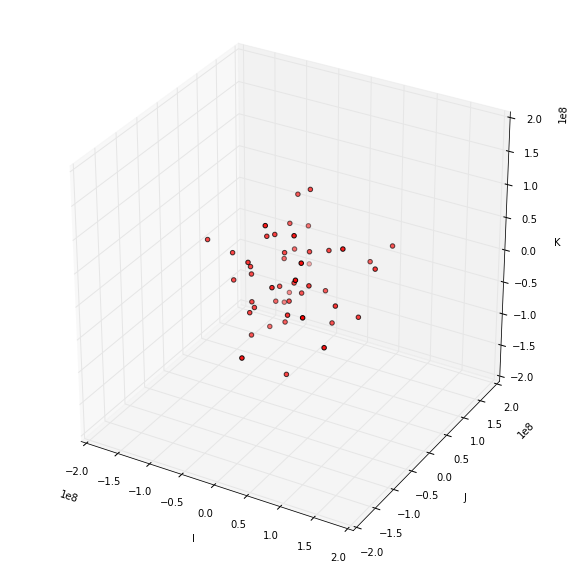

In [4]:
fig_0 = plt.figure(figsize=(10,10))
ax_0 = fig_0.add_subplot(111, projection='3d')
ax_0.scatter(xyzDistribution[:,0], xyzDistribution[:,1], xyzDistribution[:,2], c='r')

plt.xlim(-2e8, 2e8)
plt.ylim(-2e8, 2e8)
ax_0.set_zlim(-2e8,2e8)
ax_0.set_xlabel('I')
ax_0.set_ylabel('J')
ax_0.set_zlabel('K')

#print(xyzDistribution)

In [5]:
def gravity(xyzDistribution, t):
    
    global velocityDistribution
#    global xyDistribution
    global h
    
    deltaV = np.zeros_like(xyzDistribution, dtype = np.float)
    for j in range(0, nParticles):
        for k in range(0, nParticles):
            if (k!=j):
                xdist = (xyzDistribution[j,0]-xyzDistribution[k,0])
                ydist = (xyzDistribution[j,1]-xyzDistribution[k,1])
                zdist = (xyzDistribution[j,2]-xyzDistribution[k,2])
#                 print "time step ", t
#                 print "z distance ", zdist
#                 print "y distance ", ydist
#                 print "x distance ", xdist
#                print xyDistribution
#                print "xdist:", xdist
#                print(ydist)

# X Component of Force
                if(abs(xdist)<1e7):
                    deltaV[j,0] -= 0
#                    print "X less than smoothing"
                else:
                    deltaV[j,0] += -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)
                #print "distance ", (np.sqrt(xdist**2+ydist**2+zdist**2))

# Y Component of Force
                if(abs(ydist)<1e7):
                    deltaV[j,1] -= 0
#                    print "Y less than smoothing"
                else:
                    deltaV[j,1] += -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)

# Z Component of Force
                if(abs(zdist)<1e7):
                    deltaV[j,2] -= 0
#                    print "Z less than smoothing"
                else:
                    deltaV[j,2] += -G*mDistribution[j]*zdist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)
    

    #print(deltaV)
    return deltaV

nb_gravity = nb.autojit(gravity)

In [6]:
# RK1 Parameters
t0 = time.time()
t = 0
#dt = 1e1
#stepN = 20

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,3))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyzDistributionOld = np.copy(xyzDistribution)
# Velocity History
ParticleVelocityHistory = np.zeros((stepN,nParticles,3))

# Force history
forceHistory = np.zeros((stepN, 3))

deltaVf = np.zeros_like(xyzDistribution, dtype = np.float)

for i in range(stepN):
    if i % 50 == 0:
        print "Time step", i
    if i == 2:
        rhoOld = np.copy(rhoDistribution)
    deltaVf = np.zeros_like(xyzDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyzDistribution
    ParticleVelocityHistory[i,:,:] = velocityDistribution
    
    deltaVf += nb_gravity(xyzDistribution, i) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.median(deltaVf)
    
    
#     deltaVf -= -gradP()/rhoDistribution[:,np.newaxis]
# #    print "Avg gravity + pressure", np.mean(deltaVf)
#     forceHistory[i,1] = np.mean(deltaVf)

#    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
#    forceHistory[i,2] = np.mean(-v*velocityDistribution**1)
    
    velocityDistribution += dt*deltaVf    
    xyzDistribution += dt*velocityDistribution

#    densityUpdate()
#    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
#    pressureDistribution = K*rhoDistribution**2

    ### --- DEBUGGING --- ###
#    print xyDistribution[0,0] - xyDistribution[1,0]


print(time.time()-t0)
#print(rhoDistribution-rhoOld)
#print(xyDistribution-xyDistributionOld) 


Time step 0
Time step 50
Time step 100
Time step 150
Time step 200
Time step 250
Time step 300
Time step 350
Time step 400
Time step 450
Time step 500
Time step 550
Time step 600
Time step 650
Time step 700
Time step 750
Time step 800
Time step 850
Time step 900
Time step 950
0.441375017166


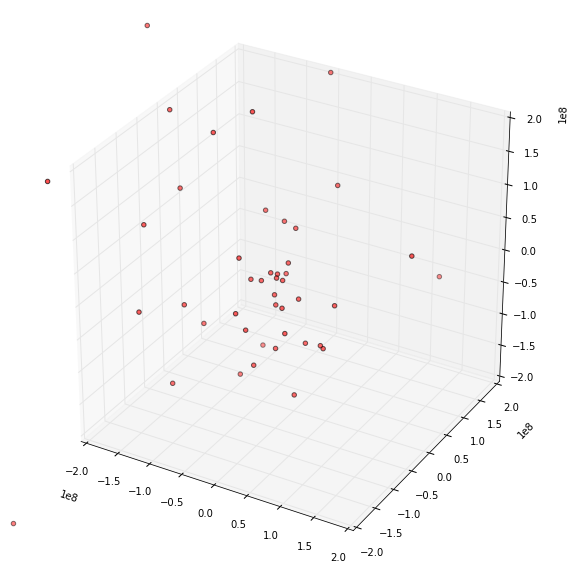

In [7]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    z = ParticlePositionHistory[time-1,:,2]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='r')
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(x, y)
    plt.xlim(-2e8,2e8)
    plt.ylim(-2e8,2e8)
    ax.set_zlim(-2e8,2e8)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

[[  4.30262403e+08   1.37354803e+09   5.47823109e+08]
 [ -9.15621870e+07  -2.18028620e+08  -9.78532842e+04]
 [  8.59816189e+07   4.56834345e+07  -5.11526850e+07]
 [  1.61414098e+07   4.44316594e+07  -1.58318921e+07]
 [ -1.54712876e+08  -6.25195978e+07  -2.55688390e+07]
 [ -8.11980998e+07   7.55156027e+07  -1.17847876e+07]
 [ -1.99227265e+07   4.54138652e+06  -1.29129016e+08]
 [ -8.08543753e+07  -2.09071358e+08   2.21796421e+05]
 [  8.25401366e+08  -1.89151706e+08  -2.12150076e+08]
 [ -1.52904954e+08  -5.69666678e+07  -2.40307016e+08]
 [ -4.24408965e+07  -6.05105532e+07  -2.05611809e+08]
 [ -1.08625468e+08   1.21429542e+08  -1.65250431e+08]
 [  2.25592136e+08  -1.82399084e+09  -1.65075530e+09]
 [  1.05851639e+08   9.02651775e+06   3.37594610e+06]
 [  6.41486780e+06   3.61837790e+07  -5.51168370e+07]
 [  3.70053211e+07  -2.99319711e+07  -4.46116408e+07]
 [ -3.58488283e+07  -7.38236857e+07   9.18011138e+07]
 [ -2.31538505e+08   7.37490183e+07   1.86740726e+07]
 [  4.50568061e+06  -2.54161

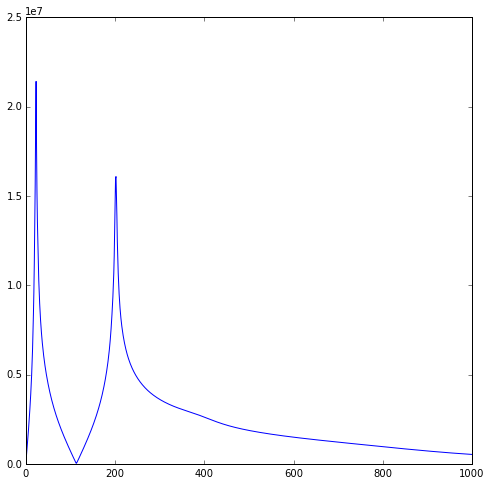

In [8]:
plt.figure(figsize=(8,8))
# plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), abs(np.sqrt((ParticleVelocityHistory[:,0,0])**2+(ParticleVelocityHistory[:,0,1])**2)))
print(xyzDistribution-xyzDistributionOld)

Velocity Asymptotes $\implies$ Force goes to zero (Good thing)